In [1]:
from graphviz import Digraph

from neural.core import Addition, Multiplication, Node, Power, Tanh, Value


SYMBOLS = {
  Addition: "+",
  Multiplication: "*",
  Power: "**",
  Tanh: "tanh",
  Value: None,
}


def symbol(node):
  return SYMBOLS[type(node)]


def trace(root):
  nodes, edges = set(), set()
  stack = [root]

  while len(stack) > 0:
    node = stack.pop()
    nodes.add(node)
    for pred in node.pred:
      edges.add((pred, node))
      stack.append(pred)

  return nodes, edges


def render(root, labels = {}, grads = {}):
  dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
  
  nodes, edges = trace(root)

  nid = lambda node: str(id(node))
  oid = lambda node, op: f"{nid(node)}-{op}"

  for node in nodes:
    label = f"{node.data:.4f}"
    label = f"{{ {labels[node]} | {label} }}" if node in labels else label

    dot.node(name=nid(node), label=label, shape="record")
    op = symbol(node)

    if op is not None:
      dot.node(name=oid(node, op), label=op, shape="circle")
      dot.edge(oid(node, op), nid(node))

  for start, end in edges:
    op = symbol(end)
    label = f"{grads[start]:.4f}" if start in grads else None

    if op is not None:
      dot.edge(nid(start), oid(end, op), label=label)
    else:
      dot.edge(nid(start), nid(end), label=label)
  
  return dot

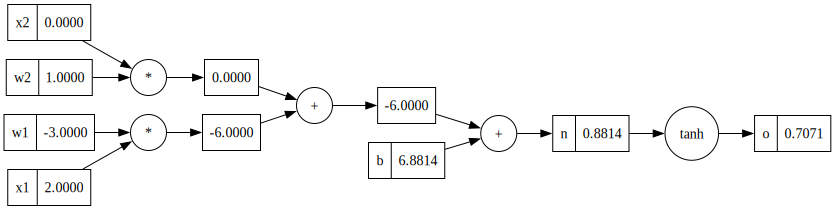

In [2]:
from neural.core import tanh

x1 = Value(2.0)
x2 = Value(0.0)

w1 = Value(-3.0)
w2 = Value(1.0)

b = Value(6.8813735870195432)

n = (x1 * w1) + (x2 * w2) + b
o = tanh(n)

labels = {x1: "x1", x2: "x2", w1: "w1", w2: "w2", b: "b", n: "n", o: "o"}

render(o, labels=labels)

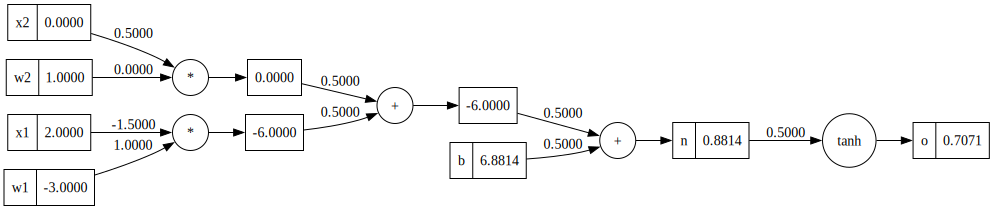

In [4]:
from neural.core import backprop

grads = backprop(o)

render(o, labels=labels, grads=grads)